In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Set image size
IMG_SIZE = 128

# Load images (RGB)
def load_images(path):
    images = []
    for file in os.listdir(path):
        img = load_img(os.path.join(path, file), target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

# Load segmentation masks (Grayscale)
def load_masks(path):
    masks = []
    for file in os.listdir(path):
        img = load_img(os.path.join(path, file), target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
        img = img_to_array(img) / 255.0  # Normalize to [0,1]
        img = np.expand_dims(img, axis=-1)  # Add channel dimension (H, W, 1)
        masks.append(img)
    return np.array(masks)

# Set dataset paths
image_path = "C:\\Users\\srika\\Downloads\\tumor_segmentation_project\\images"
mask_path = "C:\\Users\\srika\\Downloads\\tumor_segmentation_project\\masks"

# Load dataset
X = load_images(image_path)
y = load_masks(mask_path)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    c4 = Dropout(0.3)(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u1 = UpSampling2D((2,2))(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(u1)
    c5 = BatchNormalization()(c5)
    
    u2 = UpSampling2D((2,2))(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)
    
    u3 = UpSampling2D((2,2))(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u3)
    c7 = BatchNormalization()(c7)
    
    outputs = Conv2D(1, (1,1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train model
model = unet_model()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# Save trained model
model.save("optimized_brain_tumor_segmentation.h5")



Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 600s 4s/step - accuracy: 0.8066 - loss: 0.5959 - val_accuracy: 0.9829 - val_loss: 0.2692
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 575s 4s/step - accuracy: 0.9861 - loss: 0.1220 - val_accuracy: 0.9829 - val_loss: 0.1071
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 572s 4s/step - accuracy: 0.9877 - loss: 0.0538 - val_accuracy: 0.8932 - val_loss: 0.2724
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 575s 4s/step - accuracy: 0.9879 - loss: 0.0424 - val_accuracy: 0.9868 - val_loss: 0.0452
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 572s 4s/step - accuracy: 0.9901 - loss: 0.0317 - val_accuracy: 0.9868 - val_loss: 0.0522
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 573s 4s/step - accuracy: 0.9911 - loss: 0.0266 - val_accuracy: 0.9900 - val_loss: 0.0313
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 579s 4s/step - accuracy: 0.9919 - loss: 0.0235 - val_accuracy: 0.9908 - val_loss: 0.0275
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 570s 4s/step - accuracy: 0.9934 - loss: 0.0193 - val_accu

In [3]:
# Tumor Detection and Visualization
def segment_brain_tumor(image_path, model):
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    pred_mask = model.predict(img_array)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold
    
    return img, pred_mask

def check_tumor(mask):
    return np.sum(mask) > 0  # If mask has non-zero pixels, tumor exists

In [4]:
# Select and Predict Tumor
def select_image_and_predict(image_path):
    model = tf.keras.models.load_model("optimized_brain_tumor_segmentation.h5")
    original, mask = segment_brain_tumor(image_path, model)
    predicted_mask = mask.squeeze()
    
    tumor_exists = check_tumor(mask)
    print("Tumor Detected!" if tumor_exists else "No Tumor Found.")
    
    # Display MRI Image and Predicted Mask
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original MRI")
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Predicted Tumor Mask")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
Tumor Detected!


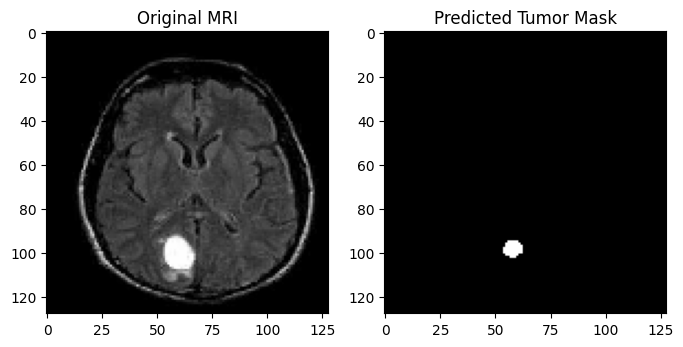

In [15]:
# Example usage
image_path = "C:\\Users\\srika\\Downloads\\sample test 1.png"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
No Tumor Found.


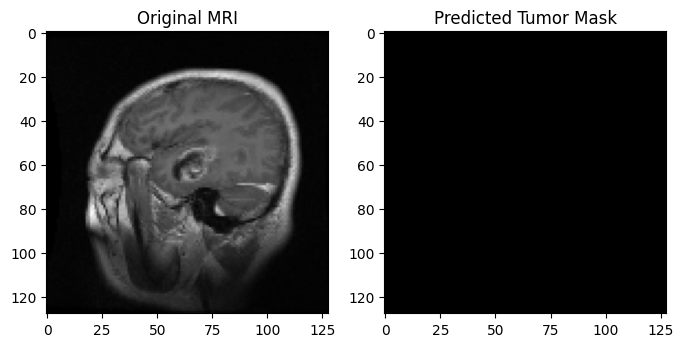

In [10]:
# Example usage
image_path = "C:\\Users\\srika\\Downloads\\914.png"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
No Tumor Found.


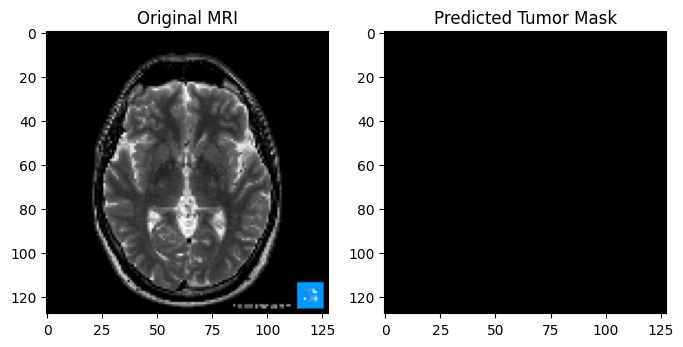

In [12]:
# Example usage
image_path = "C:\\Users\\srika\\Downloads\\sample test.jpg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
No Tumor Found.


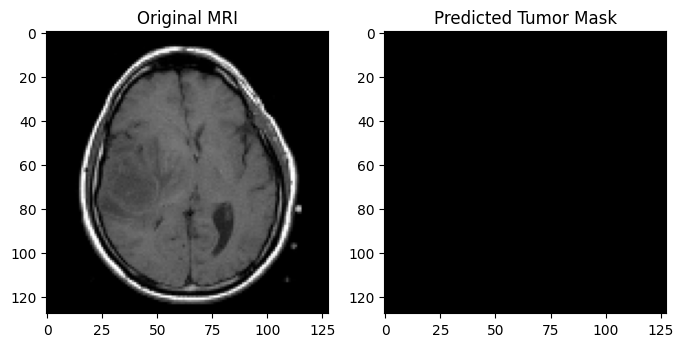

In [21]:
# Example usage
image_path = "C:\\Users\\srika\\Downloads\\sample test 3.jpg"  # Set the MRI image file path here
select_image_and_predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
No Tumor Found.


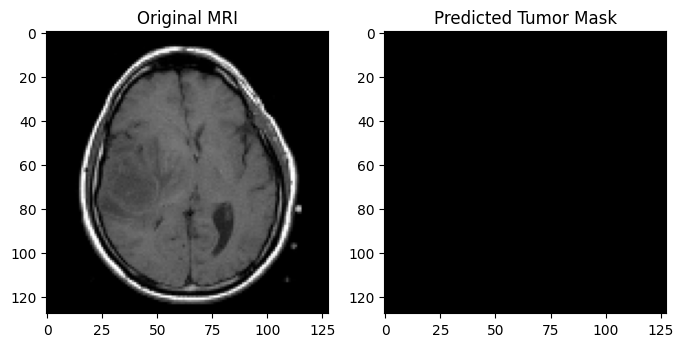

In [23]:
# Example usage
image_path = "C:\\Users\\srika\\Downloads\\sample test 4.png"  # Set the MRI image file path here
select_image_and_predict(image_path)